In [1]:
import numpy as np
import numpy.random as npr

from scipy.integrate import odeint

import matplotlib.pyplot as plt
from matplotlib import rcParams


from scipy.fftpack import fft, fftfreq, fftshift
from scipy import integrate
from scipy.optimize import curve_fit

import pandas as pd

from scipy.signal import find_peaks

In [2]:
#Données 

g = 9.81 #Valeur du champ de pesanteur
m = 1.0  #Masse scillante
l = 1.0  #Longueur du pendule


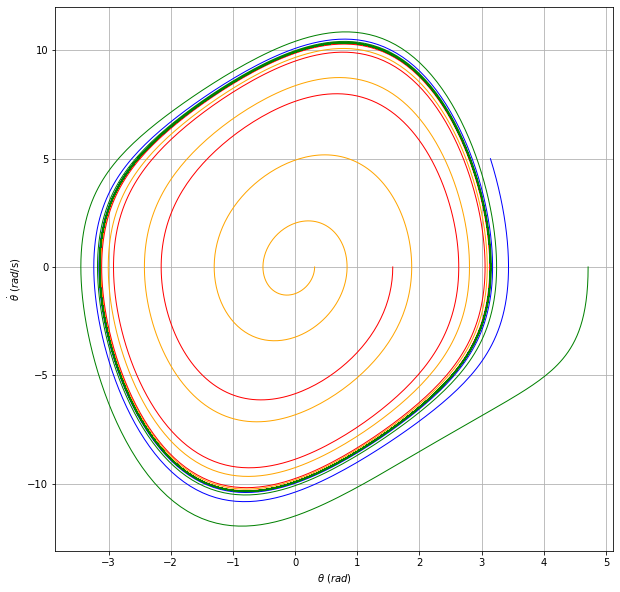

In [3]:
###Paramètres
Q = 50.0 #Facteur de qualité
thetaLim = np.pi/2
w0 = np.sqrt(g/l) #Pulsation propre


###Oscillateur harmonique non-amorti
def model_harmoniqueNonAmorti(x,t):
    return [x[1], -w0**2 * x[0]]

###Oscillateur harmonique amorti
def model_harmoniqueAmorti(x,t):
    return [x[1], -w0**2 * x[0]-x[1]*w0/Q]

###Oscillateur amorti
def model_Amorti(x,t):
    return [x[1], -w0**2 * np.sin(x[0])-x[1]*w0/Q]

###Oscillateur amorti
def model_NonAmorti(x,t):
    return [x[1], -w0**2 * np.sin(x[0])]

###Oscillateur Van der Pol

thetaLim = np.pi/2

def model_vanDerPol(x,t):
    return [x[1], -w0**2 * x[0]-x[1]*((x[0]/thetaLim)**2-1)]

###Conditions initiales
theta0 = np.pi/10
thetaPoint0 = 0

theta1 = np.pi/2
thetaPoint1 = 0

theta2 = np.pi
thetaPoint2 = 5

theta3 = 3*np.pi/2
thetaPoint3 = 0


time = np.arange (0, 100, 1e-2)

angle0, angular_velocity0 = odeint(model_vanDerPol, [theta0, thetaPoint0], time).T
angle1, angular_velocity1 = odeint(model_vanDerPol, [theta1, thetaPoint1], time).T
angle2, angular_velocity2 = odeint(model_vanDerPol, [theta2, thetaPoint2], time).T
angle3, angular_velocity3 = odeint(model_vanDerPol, [theta3, thetaPoint3], time).T

plt.figure(9,figsize=(10, 10))
plt.plot(angle0, angular_velocity0, 'orange', linewidth = 1)
plt.plot(angle1, angular_velocity1, 'red', linewidth = 1)
plt.plot(angle2, angular_velocity2, 'blue', linewidth = 1)
plt.plot(angle3, angular_velocity3, 'green', linewidth = 1)
plt.xlabel('$\\theta$ ($rad$)')
plt.ylabel('$\dot{\\theta}$ ($rad$/s)')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.grid(True)
plt.show()

Text(0, 0.5, '$\\dot{\\theta}$ ($rad$/s)')

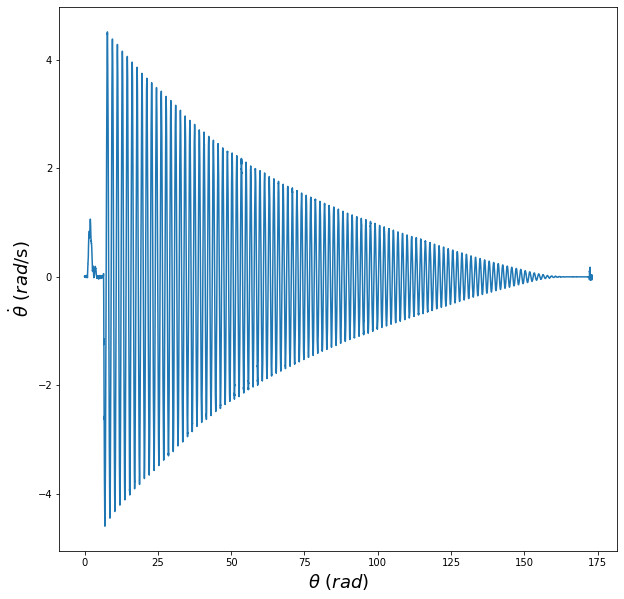

In [4]:
#Traitement données du pendule

###Extraction des données
var = pd.read_excel("borda3.xls")
t = np.array(var['Time (s)'])
theta_point_z = np.array(var['Gyroscope z (rad/s)'])

plt.figure(1,figsize=(10, 10))
plt.plot(t, theta_point_z,'-')
plt.xlabel('$\\theta$ ($rad$)', fontsize=18)
plt.ylabel('$\dot{\\theta}$ ($rad$/s)', fontsize=18)

Text(0, 0.5, '$\\theta$ ($deg$)')

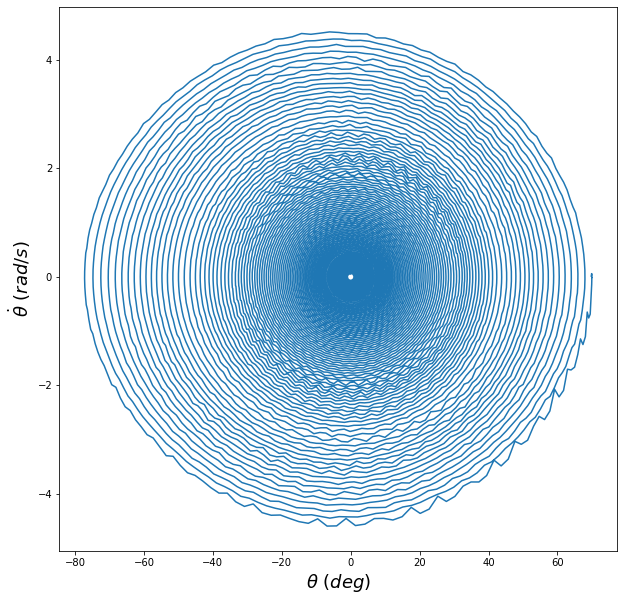

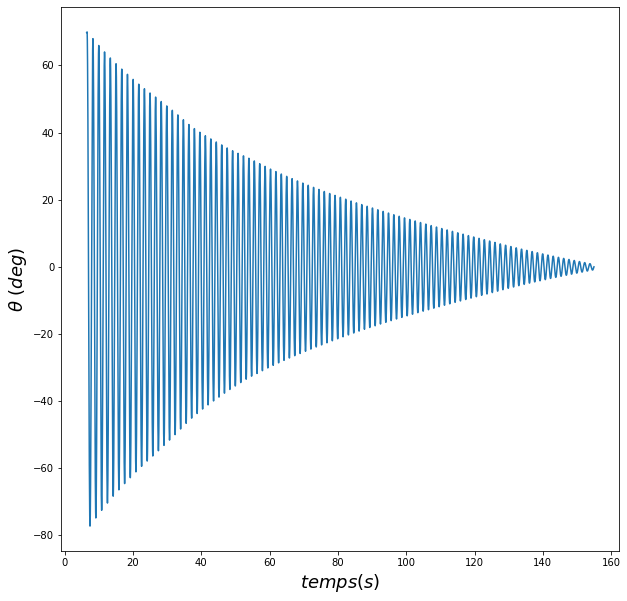

In [5]:
###Paramètres
time_min = 6.4
time_max = 155
thetaInit = 70

###Selection de la zone d'intérêt
indexMin = np.where(t>time_min)[0][0] 
indexMax = np.where(t>time_max)[0][0]

t = t[indexMin:indexMax]
theta_point_z = theta_point_z[indexMin:indexMax]

###Intégration de la vitesse angulaire et réajustement de la position
theta_z = np.full(len(t), 0.0)

theta_z = integrate.cumtrapz(theta_point_z, t, initial=0)
theta_z = thetaInit*(theta_z-theta_z[-1])/max(theta_z-theta_z[-1])


plt.figure(3,figsize=(10, 10))
plt.plot(theta_z, theta_point_z,'-')
plt.xlabel('$\\theta$ ($deg$)', fontsize=18)
plt.ylabel('$\dot{\\theta}$ ($rad/s$)', fontsize=18)

plt.figure(2,figsize=(10, 10))
plt.plot(t, theta_z,'-')
plt.xlabel('$temps (s)$', fontsize=18)
plt.ylabel('$\\theta$ ($deg$)', fontsize=18)


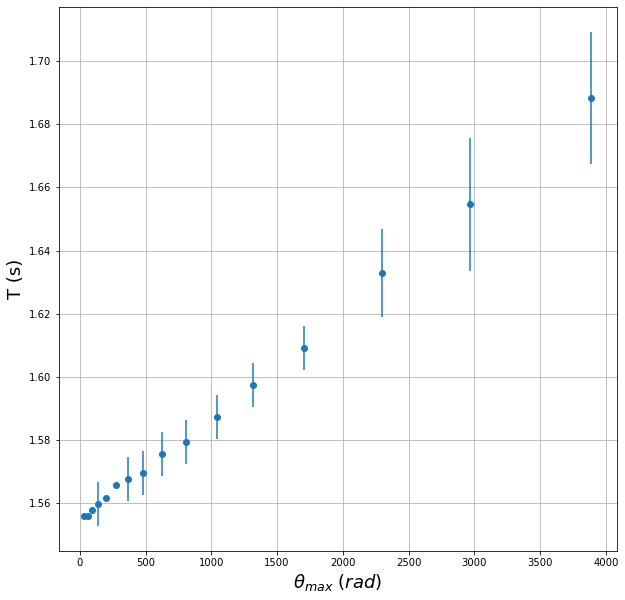

In [16]:
###Calcul des périodes d'oscillation
T_mes = np.array([])

peaks, _ = find_peaks(theta_z, width = 10) #Les maxima de position seront considérés comme les
                                           #positions initiales d'une oscillation 
for i in range (0, len(t[peaks])-1) : 
    T_mes = np.append(T_mes, t[peaks][i+1]-t[peaks][i])

theta_zMaxes = np.delete(theta_z[peaks], 0, 0) #Ajustement pour avoir le même nombre d'éléments dans la liste

###Moyennage des périodes
T_mes_av = np.array([])
theta_zMaxes_av = np.array([])

U_T_mes_av = np.array([])
U_theta_zMaxes_av = np.array([])


N_moy = 5 #Nombre de points dans la moyenne

for i in range (int(len(T_mes)/N_moy)):
    k = 0
    T_temp = 0
    theta_zMaxes_temp = 0
    while (k<N_moy):
        if ((N_moy*i+k)<len(T_mes)) :
            T_temp += T_mes[N_moy*i+k]
            theta_zMaxes_temp += theta_zMaxes[N_moy*i+k]
            k += 1
        else : break
    if k == 0 : break
    
    T_mes_av = np.append(T_mes_av, T_temp/k)
    theta_zMaxes_av = np.append(theta_zMaxes_av, theta_zMaxes_temp/k)
    
    U_T_mes_av = np.append(U_T_mes_av, np.abs(T_mes[N_moy*i+k-1]-T_mes[N_moy*i])/np.sqrt(2))
    U_theta_zMaxes_av = np.append(U_theta_zMaxes_av, np.abs(theta_zMaxes[N_moy*i+k-1]-theta_zMaxes[N_moy*i])/np.sqrt(5))

###Selection
theta_zMin = 5.0
indexTheta_zMax = np.where(theta_zMaxes_av<theta_zMin)[0][0] 

theta_zMaxes_av = theta_zMaxes_av[:indexTheta_zMax]
T_mes_av = T_mes_av[:indexTheta_zMax]
U_theta_zMaxes_av = U_theta_zMaxes_av[:indexTheta_zMax]
U_T_mes_av = U_T_mes_av[:indexTheta_zMax]

plt.figure(4,figsize=(10, 10))
plt.errorbar(theta_zMaxes_av**2, T_mes_av, xerr=U_theta_zMaxes_av, yerr=U_T_mes_av, fmt='o')
plt.grid(which='both')
plt.xlabel('$\\theta_{max}$ ($rad$)', fontsize=18)
#plt.xlabel('$\\theta_{max}^2$ ($rad^2$)', fontsize=18)
plt.ylabel('T (s)', fontsize=18)
plt.show()

In [17]:
theta_zMaxes_av = theta_zMaxes_av*np.pi/180 #conversion en radiant pour le fit
U_theta_zMaxes_av = U_theta_zMaxes_av*np.pi/180 #conversion en radiant pour le fit

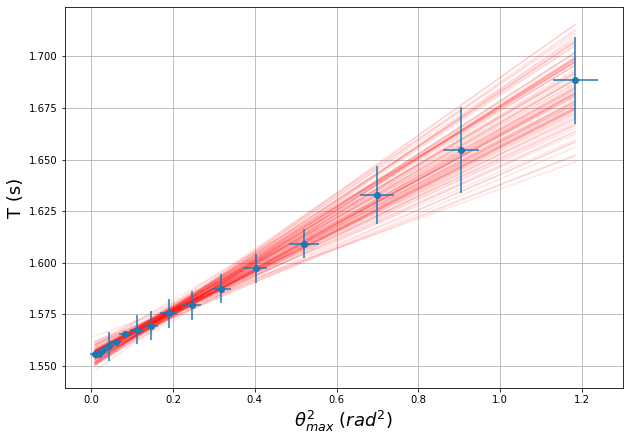

In [21]:
#Monte-Carlo
def f_lin(x,a,b):
    return a*x+b


N_mc = 100 # nombre de simulations
param = np.zeros((2, N_mc))



for i in range(N_mc):
    
    T_mc = np.array([])
    theta_zMaxes_mc = np.array([])
    
    for k in range (len(T_mes_av)) :
        T_mc = np.append(T_mc, npr.normal(loc=T_mes_av[k], scale=U_T_mes_av[k]))
        theta_zMaxes_mc = np.append(theta_zMaxes_mc, npr.normal(loc=theta_zMaxes_av[k], scale=U_theta_zMaxes_av[k]))
            
    pop, covop = curve_fit(f_lin, theta_zMaxes_mc**2, T_mc)
    param[0,i] = pop[0]
    param[1,i] = pop[1]

x_th = np.linspace(0, 1.5, 4)

plt.figure(5, figsize=(10,7))
for i in range(N_mc):
    y_th = f_lin(theta_zMaxes_av**2, *param[:,i])
    plt.plot(theta_zMaxes_av**2, y_th,'r', alpha=0.1)
plt.errorbar(theta_zMaxes_av**2, T_mes_av, xerr=U_theta_zMaxes_av, yerr=U_T_mes_av, fmt='o')
plt.grid(which='both')
plt.xlabel('$\\theta_{max}^2$ ($rad^2$)', fontsize=18)
plt.ylabel('T (s)', fontsize=18)
plt.show()    


In [8]:
###Résultat et vérification de la formule de Borda

a_moy = np.mean(param[0,:])
a_sig = np.std(param[0,:])
print(f"a = {a_moy:.4f} +/- {a_sig:.4f} s")
print(f"a_rel = {a_sig/a_moy*100:.0f} %\n")

b_moy = np.mean(param[1,:])
b_sig = np.std(param[1,:])
print(f"T0_Borda = {b_moy:.3f} +/- {b_sig:.3f} s")
print(f"T0_Borda_rel = {b_sig/b_moy*100:.0f} %")

# Calcul de la période propre
l = 665e-3   # longueur du pendule (distance axe de rotation-centre de masse) 
sigma_l = 5e-3
g = 9.81
N_mc = 100 # nombre de simulations
param2 = np.zeros(N_mc)
for i in range(N_mc):
    l_mc = npr.triangular(l-sigma_l, l, l+sigma_l)
    param2[i] = 2 * np.pi * np.sqrt(l_mc/g)
T0 = np.mean(param2)
sigma_T0 = np.std(param2)
print(f"T0 = {T0:.3f} +/- {sigma_T0:.3f} s\n")

# Calcul de la fréquence propre
f0 = 1/T0
sigma_f0 = sigma_T0/T0**2
print(f"f0 = {f0:.3f} +/- {sigma_f0:.3f} Hz\n")

# Calcul du coefficient de la formule de Borda
N_mc = 100 # nombre de simulations
param3 = np.zeros(N_mc)
for i in range(N_mc):
    a_mc = npr.normal(loc=a_moy, scale=a_sig)
    T0_mc = npr.normal(loc=T0, scale=sigma_T0)
    param3[i] = a_mc/T0_mc
coef = np.mean(param3)
sigma_coef = np.std(param3)

print(f"Coefficient expérimental = {coef:.3f} +/- {sigma_coef:.3f}")
print(f"Coefficient théorique = 1/16 = 0.0625")

a = 0.1073 +/- 0.0137 s
a_rel = 13 %

T0_Borda = 1.555 +/- 0.003 s
T0_Borda_rel = 0 %
T0 = 1.636 +/- 0.002 s

f0 = 0.611 +/- 0.001 Hz

Coefficient expérimental = 0.067 +/- 0.008
Coefficient théorique = 1/16 = 0.0625


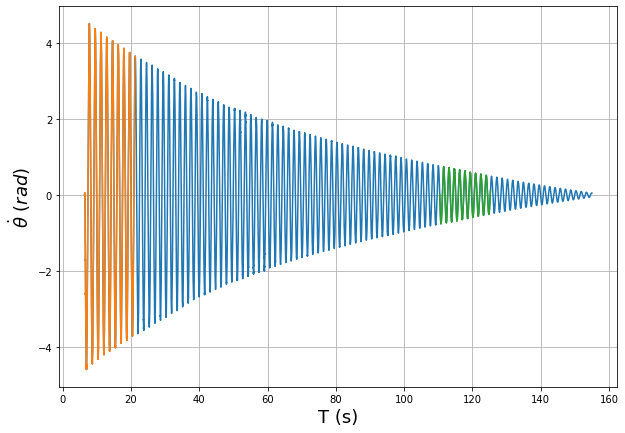

In [9]:
###Apparition d'harmonique d'ordre 3

plt.figure(4, figsize=(10,7))
plt.plot(t, theta_point_z)
plt.plot(t[0:int(0.1*len(t))], theta_point_z[0:int(0.1*len(t))])
plt.plot(t[int(0.7*len(t)):int(0.8*len(t))], theta_point_z[int(0.7*len(t)):int(0.8*len(t))])
plt.ylabel('$\dot{\\theta}$ ($rad$)', fontsize=18)
plt.xlabel('T (s)', fontsize=18)
plt.grid()
plt.show()

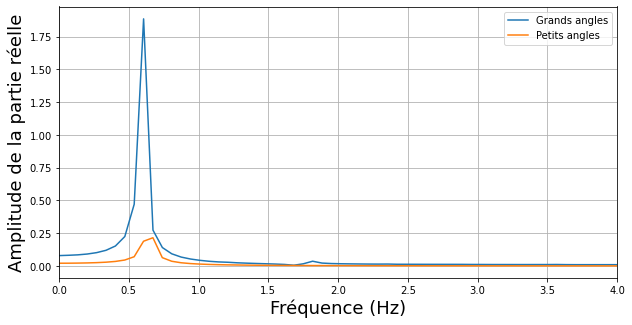

In [10]:
dt = t[1]-t[0]

yf = fft(theta_point_z[0:int(0.1*len(t))])     # .values
xf = fftfreq(len(t[0:int(0.1*len(t))]), dt)
xf = fftshift(xf)
yplot = fftshift(yf)
plt.figure(7, figsize=(10, 5))
plt.plot(xf, 1.0/len(t[0:int(0.1*len(t))]) * np.abs(yplot), label='Grands angles')
plt.xlim(0, 4)
plt.grid()
plt.ylabel('Amplitude de la partie réelle', fontsize=18)
plt.xlabel('Fréquence (Hz)', fontsize=18)

yf = fft(theta_point_z[int(0.7*len(t)):int(0.8*len(t))]) # .values
xf = fftfreq(len(t[int(0.7*len(t)):int(0.8*len(t))]), dt)
xf = fftshift(xf)
yplot = fftshift(yf)
plt.plot(xf, 1.0/len(t[int(0.7*len(t)):int(0.8*len(t))]) * np.abs(yplot), label='Petits angles')
plt.legend()
plt.show()